In [2]:
import pandas as pd
import numpy as np

import pymc as pm
import pymc_experimental as pmx

import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 100

plt.style.use('default')
sns.set_style("whitegrid")

SEED = 12345
np.random.seed(SEED)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [4]:
# generate synthetic data
np.random.seed(42)

N = 1_000

# zero-inflation proportion
control_p = 0.15
treated_p = 0.07

control_zif = np.random.binomial(1, p=control_p, size=N)
treated_zif = np.random.binomial(1, p=treated_p, size=N)

# volume
control_group = np.random.lognormal(5.8, 0.8, size=N)
treated_group = np.random.lognormal(6.0, 0.5, size=N)

# data
control_data = np.where(control_zif == 1, 0, control_group)
treated_data = np.where(treated_zif == 1, 0, treated_group)

# dataframe
df = pd.DataFrame({
    'group': ['control'] * N + ['treated'] * N,
    'volume': np.hstack((control_data, treated_data))
})

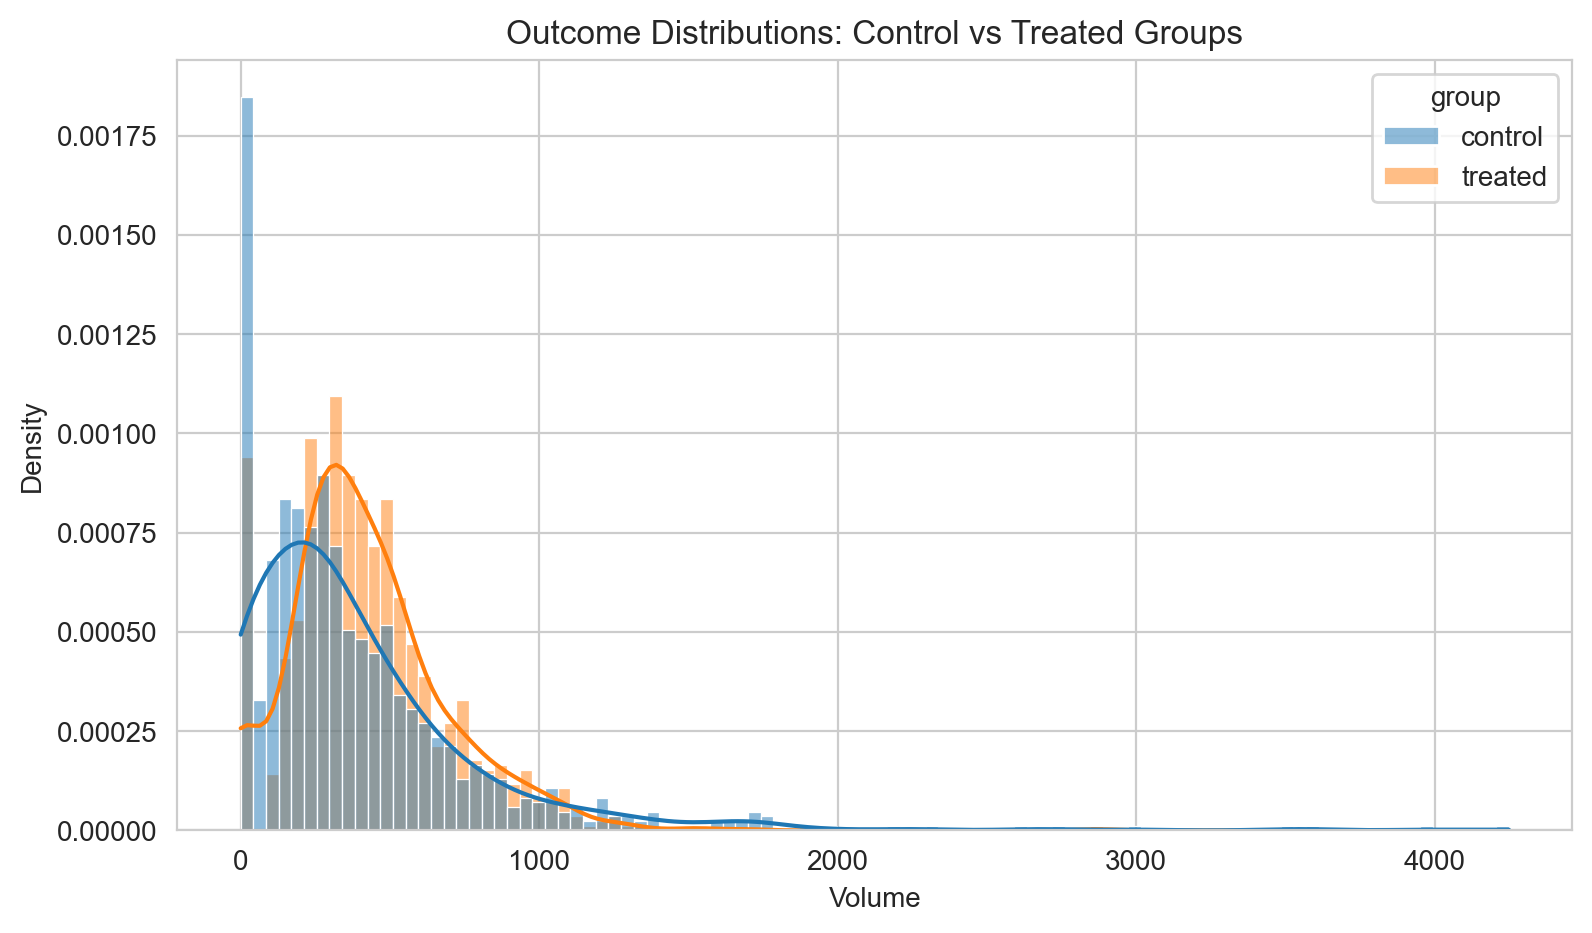

In [6]:
# plot the distribution of outcomes for both groups
fig, ax = plt.subplots(1, 1, figsize=(9, 5))

sns.histplot(
    df, 
    x='volume', 
    hue='group', 
    kde=True, 
    stat='density',
    bins=100,
    ax=ax
)
ax.set(
    title='Outcome Distributions: Control vs Treated Groups',
    xlabel='Volume',
    ylabel='Density'
);

In [5]:
group_idx, groups = pd.factorize(df['group'], sort=True)
n_groups = groups.size

control_data = df.query("group == 'control'").get('volume').to_numpy()
treated_data = df.query("group == 'treated'").get('volume').to_numpy()

In [6]:
COORDS = {
    'group': list(df['group'].unique())
}

mean_dict = {
    "control": np.log(control_data[control_data > 0]).mean(),
    "treated": np.log(treated_data[treated_data > 0]).mean()
}

std_dict = {
    "control": np.log(control_data[control_data > 0]).std(),
    "treated": np.log(treated_data[treated_data > 0]).std()
}

## Difference in Means

 * [A guide to modeling outcomes that have lots of zeros with Bayesian hurdle lognormal model - Andrew Heiss](https://www.andrewheiss.com/blog/2022/05/09/hurdle-lognormal-gaussian-brms/)

 * From this blog post we know that the expected value (i.e. mean) of the zero-inflated lognormal distribution is the following:

$$
E[Y] = (1 - \text{hu}) \times \exp^{\mu + (\sigma^{2}) / 2}
$$

 * So is essentially the mean of the $LogNormal$ distribution multiplied by the proportion of users that **_weren't_** a zero value.

In [7]:
with pm.Model(coords=COORDS) as model:

    # priors for the mean in log scale
    group1_mu = pm.Normal('mu1', mu=mean_dict['control'], sigma=std_dict['control']*2)
    group2_mu = pm.Normal('mu2', mu=mean_dict['treated'], sigma=std_dict['treated']*2)

    # priors for the stf dev in log scale
    group1_sd = pm.HalfNormal('sd1', 1)
    group2_sd = pm.HalfNormal('sd2', 1)

    # uninformative prior 
    group1_p = pm.Beta('p1', 2., 2)
    group2_p = pm.Beta('p2', 2., 2)

    # zero-inflation percentage
    group1_zif = pm.Deterministic('zif1', (1 - group1_p))
    group2_zif = pm.Deterministic('zif2', (1 - group2_p))

    pm.HurdleLogNormal("control", psi=group1_p, mu=group1_mu, sigma=group1_sd, observed=control_data)
    pm.HurdleLogNormal("treatment", psi=group2_p, mu=group2_mu, sigma=group2_sd, observed=treated_data)

    # zero-inflated lognormal mean
    group1_mean = pm.Deterministic('group1_mean', group1_p * np.exp(group1_mu + 0.5 * np.square(group1_sd)))
    group2_mean = pm.Deterministic('group2_mean', group2_p * np.exp(group2_mu + 0.5 * np.square(group2_sd)))

    # difference of means
    diff_of_mus = pm.Deterministic("diff_of_mus", group2_mean - group1_mean)

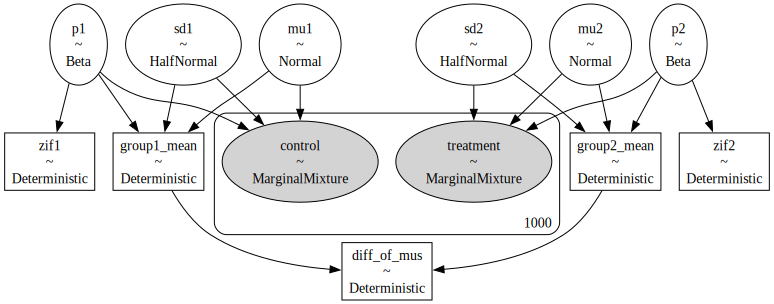

In [8]:
pm.model_to_graphviz(model)

In [9]:
with model:
    idata = pm.sample(draws=2000, tune=1000, chains=4, target_accept=0.85)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu1, mu2, sd1, sd2, p1, p2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


In [10]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu1,5.822,0.027,5.770,5.873,0.000,0.000,9885.0,6688.0,1.0
mu2,5.997,0.017,5.965,6.028,0.000,0.000,10406.0,6377.0,1.0
sd1,0.784,0.019,0.749,0.822,0.000,0.000,9548.0,6033.0,1.0
sd2,0.517,0.012,0.496,0.540,0.000,0.000,8880.0,6159.0,1.0
p1,0.845,0.012,0.825,0.868,0.000,0.000,10274.0,6686.0,1.0
p2,0.918,0.009,0.902,0.935,0.000,0.000,10475.0,6481.0,1.0
zif1,0.155,0.012,0.132,0.175,0.000,0.000,10274.0,6686.0,1.0
zif2,0.082,0.009,0.065,0.098,0.000,0.000,10475.0,6481.0,1.0
group1_mean,388.334,13.307,362.800,413.301,0.135,0.096,9796.0,6335.0,1.0
group2_mean,422.435,8.561,405.812,437.935,0.083,0.059,10568.0,6468.0,1.0


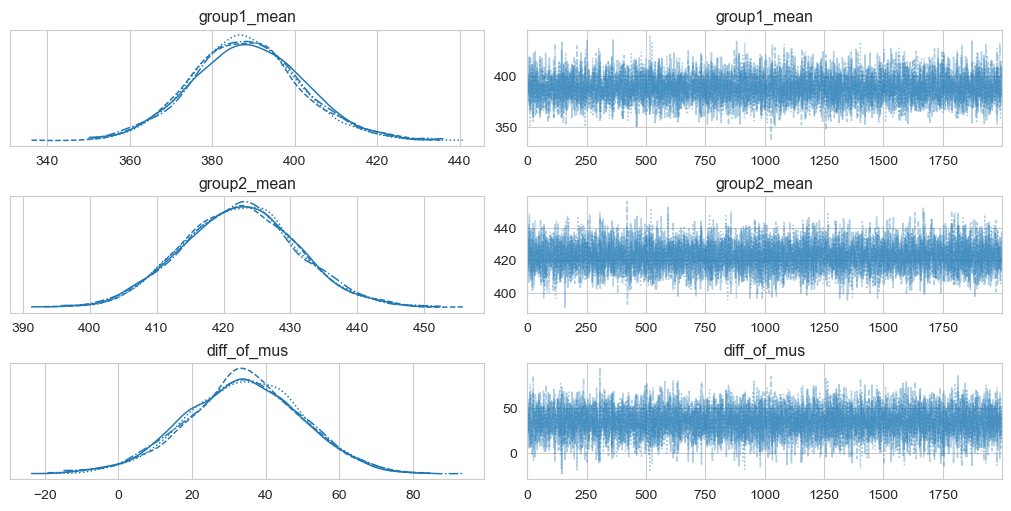

In [11]:
az.plot_trace(
    idata, 
    var_names=['group1_mean', 'group2_mean', 'diff_of_mus'],
    backend_kwargs=dict(constrained_layout=True, figsize=(10, 5))
);

In [12]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(idata, var_names=['control', 'treatment'])

Sampling: [control, treatment]


Output()

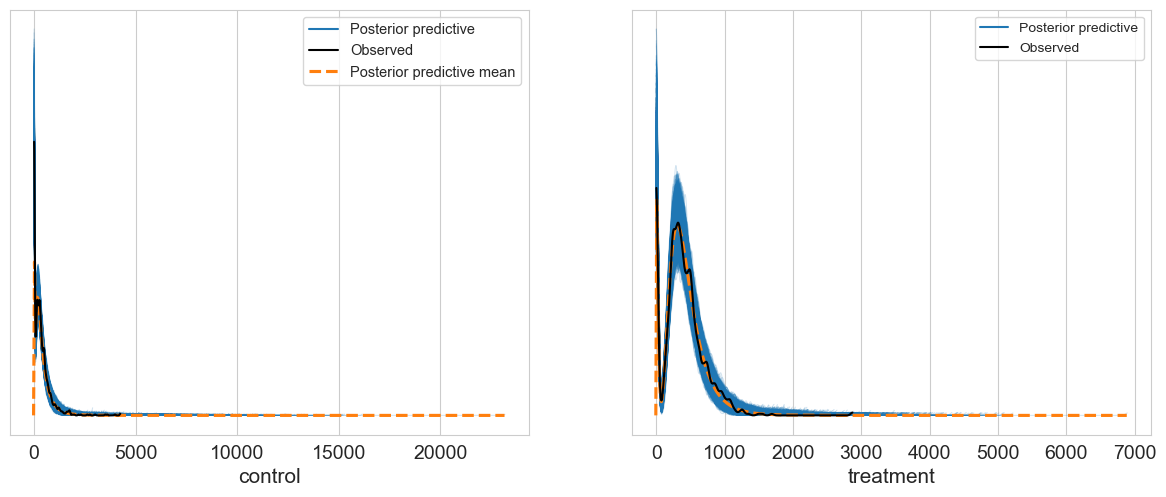

In [13]:
az.plot_ppc(posterior_predictive);

## Scalable Model

 * [Bayesian inference at scale: Running A/B tests with millions of observations - PyMC Labs](https://www.pymc-labs.com/blog-posts/bayesian-inference-at-scale-running-ab-tests-with-millions-of-observations/)
 * Turns out we don't actually need to include all the data available to us in order to model it well.
 * Instead we can bin the data into discrete units (i.e. take the histogram) and model that instead, and it will give us the same answer.

In [14]:
# generate synthetic data
np.random.seed(42)

N = 1_000_000

# zero-inflation proportion
control_p = 0.15
treated_p = 0.07

control_zif = np.random.binomial(1, p=control_p, size=N)
treated_zif = np.random.binomial(1, p=treated_p, size=N)

# volume
control_group = np.random.lognormal(5.8, 0.8, size=N)
treated_group = np.random.lognormal(6, 0.5, size=N)

# data
control_data = np.where(control_zif == 1, 0, control_group)
treated_data = np.where(treated_zif == 1, 0, treated_group)

# Create a DataFrame for easier handling
data_df = pd.DataFrame({
    'group': ['control'] * N + ['treated'] * N,
    'volume': np.hstack((control_data, treated_data))
})

In [15]:
group_idx, groups = pd.factorize(data_df['group'], sort=True)
n_groups = groups.size

control_data = data_df.query("group == 'control'").get('volume').to_numpy()
treated_data = data_df.query("group == 'treated'").get('volume').to_numpy()

In [16]:
COORDS = {
    'group': list(data_df['group'].unique())
}

mean_dict = {
    "control": np.log(control_data[control_data > 0]).mean(),
    "treated": np.log(treated_data[treated_data > 0]).mean()
}

std_dict = {
    "control": np.log(control_data[control_data > 0]).std(),
    "treated": np.log(treated_data[treated_data > 0]).std()
}

In [17]:
with pm.Model(coords=COORDS) as model:

    # priors for the mean in log scale
    group1_mu = pm.Normal('mu1', mu=mean_dict['control'], sigma=std_dict['control']*2)
    group2_mu = pm.Normal('mu2', mu=mean_dict['treated'], sigma=std_dict['treated']*2)

    # priors for the std dev in log scale
    group1_sd = pm.HalfNormal('sd1', 1)
    group2_sd = pm.HalfNormal('sd2', 1)

    # slightly more informative prior 
    group1_p = pm.Beta('p1', 50, 200)
    group2_p = pm.Beta('p2', 50, 200)

    # zero-inflation proportion
    group1_zif = pm.Deterministic('zif1', (1 - group1_p))
    group2_zif = pm.Deterministic('zif2', (1 - group2_p))

    pmx.distributions.histogram_utils.histogram_approximation(
        "control",
        pm.HurdleLogNormal.dist(psi=group1_p, mu=group1_mu, sigma=group1_sd), 
        observed=control_data,
        n_quantiles=10_000,
        zero_inflation=True
    )

    pmx.distributions.histogram_utils.histogram_approximation(
        "treatment",
        pm.HurdleLogNormal.dist(psi=group2_p, mu=group2_mu, sigma=group2_sd), 
        observed=treated_data,
        n_quantiles=10_000,
        zero_inflation=True
    )

    # zero-inflated lognormal mean
    group1_mean = pm.Deterministic('group1_mean', group1_p * np.exp(group1_mu + 0.5 * np.square(group1_sd)))
    group2_mean = pm.Deterministic('group2_mean', group2_p * np.exp(group2_mu + 0.5 * np.square(group2_sd)))

    # difference of means
    diff_of_mus = pm.Deterministic("diff_of_mus", group2_mean - group1_mean)

/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


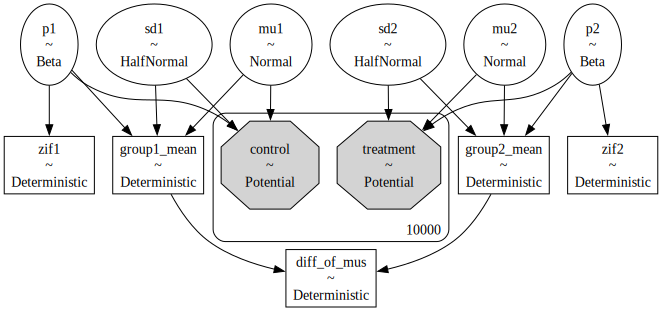

In [18]:
pm.model_to_graphviz(model)

In [19]:
%%time
with model:
    idata = pm.sample(draws=2000, tune=1000, chains=4, target_accept=0.85)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu1, mu2, sd1, sd2, p1, p2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.


CPU times: user 9.94 s, sys: 2.01 s, total: 11.9 s
Wall time: 37.8 s


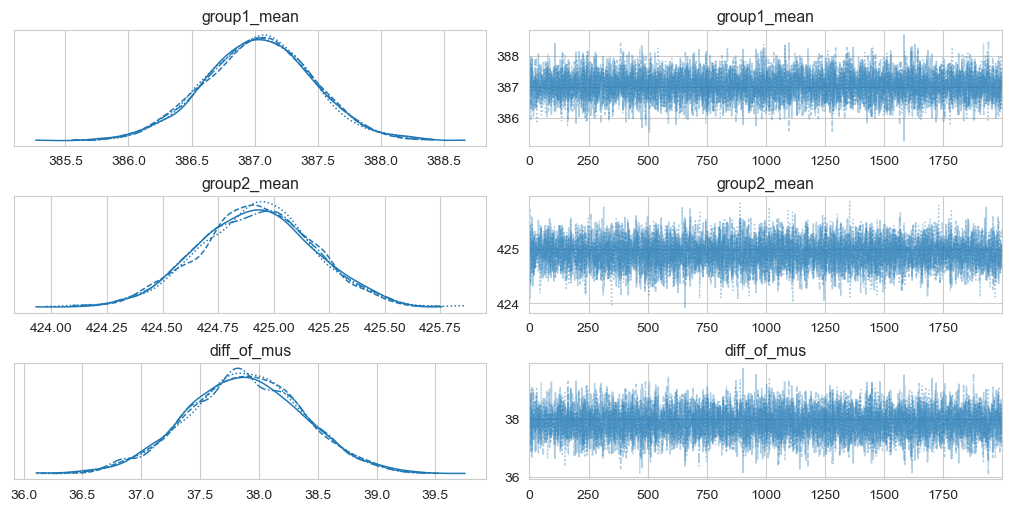

In [20]:
az.plot_trace(
    idata, 
    var_names=['group1_mean', 'group2_mean', 'diff_of_mus'],
    backend_kwargs=dict(constrained_layout=True, figsize=(10, 5))
);

In [21]:
az.summary(idata, var_names=['mu1', 'mu2', 'zif1', 'zif2', 'group1_mean', 'group2_mean', 'diff_of_mus'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu1,5.801,0.001,5.799,5.802,0.000,0.000,8482.0,6010.0,1.0
mu2,6.000,0.001,5.999,6.001,0.000,0.000,9176.0,6272.0,1.0
zif1,0.150,0.000,0.150,0.151,0.000,0.000,10641.0,6185.0,1.0
zif2,0.070,0.000,0.070,0.070,0.000,0.000,8978.0,5826.0,1.0
group1_mean,387.035,0.422,386.243,387.835,0.005,0.003,8720.0,6548.0,1.0
group2_mean,424.921,0.259,424.457,425.432,0.003,0.002,9254.0,6328.0,1.0
diff_of_mus,37.886,0.495,36.930,38.817,0.005,0.004,9122.0,6392.0,1.0


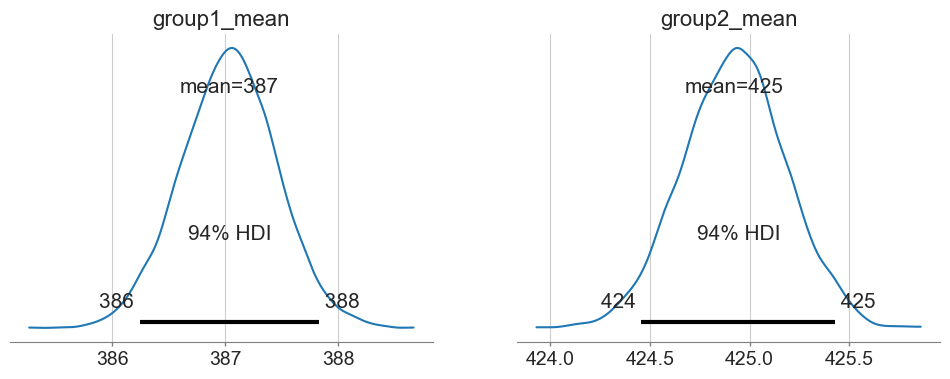

In [22]:
az.plot_posterior(
    idata, 
    var_names=['group1_mean', 'group2_mean'],
    backend_kwargs=dict(figsize=(12, 4))
);

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Oct 02 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.12.3

arviz            : 0.17.1
seaborn          : 0.13.2
pymc_experimental: 0.1.2
cycler           : 0.11.0
sys              : 3.11.9 (main, Apr 19 2024, 11:43:47) [Clang 14.0.6 ]
pymc             : 5.16.1
pandas           : 2.2.3
matplotlib       : 3.9.2
numpy            : 1.26.4

Watermark: 2.5.0

